# Dataset imports

In [1]:
# Get the file name from the uploaded files
train_file = './data/brown.train.txt'
test_file = './data/brown.test.txt'
dev_file = './data/brown.dev.txt'

# Read text from the uploaded file
with open(train_file, 'r') as file:
    train_text = file.read()

with open(test_file, 'r') as file:
    test_text = file.read()

with open(dev_file, 'r') as file:
    dev_text = file.read()

print("Text from the file(s):")

print(train_text[:500], " ...\n\n")
print(test_text[:500], " ...\n\n")
print(dev_text[:500], " ...\n\n")

Text from the file(s):
The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .
The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .
The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate and oft  ...


The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' .
The jury did not elaborate , but it added t

# Text Cleaning

- In this section, the input corpus is cleaned and **all non-alphanumeric** symbols are dropped

- `<start>` and `<stop>` tags are added at the *start* and *end* of every sentence

In [2]:
import math
import re
from collections import Counter

In [3]:
def clean_text(corpus):
  # Convert to lowercase and remove punctuation
  corpus = corpus.lower()
  cleaned_corpus = re.sub(r'[^a-zA-Z0-9\s\n]', ' ', corpus)

  return cleaned_corpus

In [4]:
def add_start_stop_tags (text):
    sentences = text.split('\n')
    tagged_sentences = ['<start> ' + sentence + ' <stop>\n' for sentence in sentences if sentence.strip()]

    return ' '.join(tagged_sentences)

In [5]:
def read_text_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        return text
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [6]:
# Loading training, dev and test corpus

train_corpus = read_text_from_file('./data/brown.train.txt') 
dev_corpus = read_text_from_file('./data/brown.dev.txt') 
test_corpus = read_text_from_file('./data/brown.test.txt') 

train_text = add_start_stop_tags(clean_text(train_corpus))
dev_text = add_start_stop_tags(clean_text(dev_corpus))
test_text = add_start_stop_tags(clean_text(test_corpus))

print ("Train Text: \n", train_text[:1000], " ...\n\n")
print ("Dev Text:   \n", dev_text[:1000], " ...\n\n")
print ("Test Text:  \n", test_text[:1000], " ...\n\n")

Train Text: 
 <start> the fulton county grand jury said friday an investigation of atlanta s recent primary election produced    no evidence    that any irregularities took place   <stop>
 <start> the september october term jury had been charged by fulton superior court judge durwood pye to investigate reports of possible    irregularities    in the hard fought primary which was won by mayor nominate ivan allen jr    <stop>
 <start> the jury said it did find that many of georgia s registration and election laws    are outmoded or inadequate and often ambiguous      <stop>
 <start> it recommended that fulton legislators act    to have these laws studied and revised to the end of modernizing and improving them      <stop>
 <start> the grand jury commented on a number of other topics   among them the atlanta and fulton county purchasing departments which it said    are well operated and follow generally accepted practices which inure to the best interest of both governments      <stop>
 <

# Vocabulary Generation (for Add-K Smoothing)

Here, `vocabulary` and `vocab_counts` are generated which are used while smoothening.

In [7]:
def generate_vocabulary (text, threshold = 2):
    # preprocessing the corpus to extract text
    # text = preprocess_corpus(corpus)

    text_words = text.split()
    word_counts = Counter (text_words)

    vocabulary = [word for word, count in word_counts.items() if count > threshold]
    return vocabulary

In [8]:
# Generating Vocabulary for Training Data (corpus)

vocabulary = generate_vocabulary(train_text, threshold=0)
vocab_size = len(vocabulary)

print (vocabulary[0:50], " ...")
print (vocab_size)

['<start>', 'the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'atlanta', 's', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took', 'place', '<stop>', 'september', 'october', 'term', 'had', 'been', 'charged', 'by', 'superior', 'court', 'judge', 'durwood', 'pye', 'to', 'investigate', 'reports', 'possible', 'in', 'hard', 'fought', 'which', 'was', 'won', 'mayor', 'nominate', 'ivan']  ...
38750


# Model Training

Here the `smooth_unigrams`, `smooth_bigrams`, and `smooth_trigrams` are trained for various `K = 1` to `10`.  

In [9]:
def train_ngram_model_addk_smoothing(text, N, K):
  # Tokenize the text into words
  words = text.split()

  # Create n-grams
  ngrams = [tuple(words[i:i+N]) for i in range(len(words) - N+1)]

  # Count the occurrences of each n-gram
  ngram_frequencies = Counter(ngrams)

  vocab_size = len(vocabulary)

  # Calculate log probabilities
  total_ngrams = len(ngrams)
  log_probabilities = {ngram: math.log((count + K) / (total_ngrams + K*vocab_size)) for ngram, count in ngram_frequencies.items()}

  return log_probabilities, ngrams

In [10]:
# Training Unigrams, Bigrams and Trigrams

K = 10

smooth_unigrams = []
smooth_bigrams = []
smooth_trigrams = []

unigrams = bigrams = trigram = []

for k in range (1, K+1):
    unigram_model, unigrams = train_ngram_model_addk_smoothing (text = train_text, N = 1, K = k)
    unigram_model[('<start>', )] = 0.00
    smooth_unigrams.append(unigram_model)

    bigram_model, bigrams = train_ngram_model_addk_smoothing (text = train_text, N = 2, K = k)
    smooth_bigrams.append(bigram_model)

    trigram_model, trigrams = train_ngram_model_addk_smoothing(text = train_text, N = 3, K = k)
    smooth_trigrams.append(trigram_model)

# printing smooth unigrams, bigrams and trigrams
for i in range (K):
    print ("Smooth Unigrams: ", i+1, ": ", list(smooth_unigrams[i].items())[:20])

print ("\n\n")

for i in range (K):
    print ("Smooth Bigrams: ", i+1, ": ", list(smooth_bigrams[i].items())[:20])

print ("\n\n")

for i in range (K):
    print ("Smooth Trigrams: ", i+1, ": ", list(smooth_trigrams[i].items())[:20])

Smooth Unigrams:  1 :  [(('<start>',), 0.0), (('the',), -2.8383022480652116), (('fulton',), -10.879804557317067), (('county',), -8.92598922875464), (('grand',), -10.081296861099295), (('jury',), -9.858153309785086), (('said',), -6.396802005303183), (('friday',), -9.838350682488906), (('an',), -5.769826819888548), (('investigation',), -9.920028713503173), (('of',), -3.4893145347354646), (('atlanta',), -10.336189110728085), (('s',), -5.247597651520656), (('recent',), -8.807331684953324), (('primary',), -9.363457067948978), (('election',), -9.580521573186806), (('produced',), -9.45268820167692), (('no',), -6.28749448705858), (('evidence',), -8.682579979980847), (('that',), -4.720474289199862)]
Smooth Unigrams:  2 :  [(('<start>',), 0.0), (('the',), -2.878031030304502), (('fulton',), -10.865483997298803), (('county',), -8.957892712545625), (('grand',), -10.096350909760936), (('jury',), -9.878097343740917), (('said',), -6.4359211171150825), (('friday',), -9.858679257883816), (('an',), -5.80

# Probability & Perplexity Calculation

The probabilities are calculated as `log_probabilities` to avoid underflow and help speed up computation. 

In [11]:
def calculate_addk_probability(N, ngram, K):
	if ngram == None:
		return float('-inf')
		
	if (N == 1):
		ngrams_count = len(unigrams)
	elif N == 2:
		ngrams_count = len(bigrams)
	else:
		ngrams_count = len(trigrams)

	ngram_log_probability = K / (ngrams_count + K*vocab_size)
	
	return ngram_log_probability

In [12]:
def calculate_perplexity(log_prob, sentence_len):
  return 2**(-log_prob/sentence_len)

# Smooth-Models Evaluation

Here, all three models are run for `K = 1` to `10`

In [13]:
def calculate_sentence_probability(N, sentence, K):
    words = sentence.split()

    ngrams = [tuple(words[i:i+N]) for i in range(len(words) - N+1)]
    
    if N == 1:
        ngram_model = smooth_unigrams[K-1]
    elif N == 2: 
        ngram_model = smooth_bigrams[K-1]
    else:
        ngram_model = smooth_trigrams[K-1]

    # Calculate the smooth probability for each word
    sentence_probability = 0
    if N == 1:
        ngram_counts = len(unigrams)
    elif N == 2:
        ngram_counts = len(bigrams)
    else:
        ngram_counts = len(trigrams)

    for ngram in ngrams:
        current_ngram_prob = ngram_model.get(ngram, float('-inf'))

        if current_ngram_prob == float('-inf'):
            current_ngram_prob = K / (ngram_counts + K*vocab_size)

        sentence_probability += current_ngram_prob

    return sentence_probability

In [14]:
K_Values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Avg_Perp = []

for k in K_Values:
    unigram_model = smooth_unigrams[k-1]

    perplexities = []
    for sentence in test_text.split("\n"):
        if not sentence.split():
            continue

        probability = calculate_sentence_probability(1, sentence, k)
        perplexity = calculate_perplexity(probability, len(sentence))

        perplexities.append(perplexity)

    avg_perplexity = sum(perplexities)/len(perplexities)
    Avg_Perp.append(avg_perplexity)

    print ("K: ", k, "\t\tAverage Perplexity: ", avg_perplexity)

K:  1 		Average Perplexity:  2.0661778049699984
K:  2 		Average Perplexity:  2.069698175390296
K:  3 		Average Perplexity:  2.0736658150034684
K:  4 		Average Perplexity:  2.0778399288230065
K:  5 		Average Perplexity:  2.082104156285152
K:  6 		Average Perplexity:  2.086394286308455
K:  7 		Average Perplexity:  2.090672186303471
K:  8 		Average Perplexity:  2.0949142478848763
K:  9 		Average Perplexity:  2.099105555862317
K:  10 		Average Perplexity:  2.1032366690274684


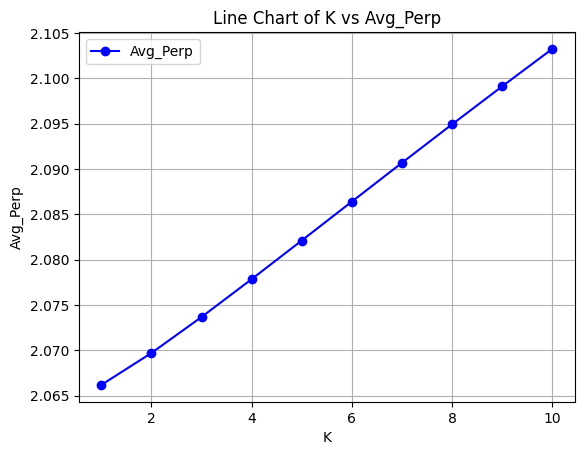

In [15]:
import matplotlib.pyplot as plt

# Plotting the line chart
plt.plot(K_Values, Avg_Perp, marker='o', linestyle='-', color='b', label='Avg_Perp')

# Adding labels and title
plt.xlabel('K')
plt.ylabel('Avg_Perp')
plt.title('Line Chart of K vs Avg_Perp')

# Adding grid
plt.grid(True)

# Adding legend
plt.legend()

# Display the plot
plt.show()


# Interpolation (`lambda1`, `lambda2`, `lamda3`)

In section, a `5x5` grid is created for lambda values, which is then searched for the best combination by contiously testing on **Dev Data** (`./data/brown.dev.txt`).

Finally, the best combination is selected for **Test Data** (`./data/brown.test.txt`)

In [16]:
def interpolate_models(unigram_model, bigram_model, trigram_model, lambda1, lambda2, lambda3, K):
    def calculate_interpolated_probability(unigram, bigram, trigram):
        # Interpolate unigram, bigram, and trigram probabilities
        prob_unigram = math.exp(unigram_model.get(unigram, calculate_addk_probability(1, unigram, K)))
        prob_bigram = math.exp(bigram_model.get(bigram, calculate_addk_probability(2, bigram, K)))
        prob_trigram = math.exp(trigram_model.get(trigram, calculate_addk_probability(3, trigram, K)))

        # Calculate the interpolated probability
        interpolated_probability = lambda1 * prob_unigram + lambda2 * prob_bigram + lambda3 * prob_trigram
        return interpolated_probability

    def calculate_sentence_probability(sentence):
        words = sentence.split()
        sentence_probability = 0.0

        for i in range(len(words)):
            unigram = words[i]
            bigram = (words[i - 1], unigram) if i > 0 else None
            trigram = (words[i - 2], words[i - 1], unigram) if i > 1 else None

            # Calculate the interpolated probability for each word
            interpolated_probability = calculate_interpolated_probability(unigram, bigram, trigram)
            sentence_probability += math.log(interpolated_probability)

        return sentence_probability

    return calculate_sentence_probability

In [17]:
from collections import namedtuple

K = 10
lambda1 = [0.1, 0.3, 0.5, 0.7, 0.9]
lambda2 = [0.2, 0.4, 0.6, 0.8, 1.0]

Param = namedtuple('Param', ['K', 'l1', 'l2', 'l3'])
best_params = Param(K = -1, l1 = -1, l2 = -1, l3 = -1)

min_avg_perplexity = float('inf')

for k in range (1, K+1):
    unigram_model = smooth_unigrams[k-1]
    bigram_model = smooth_bigrams[k-1]
    trigram_model = smooth_trigrams[k-1]

    for l1 in lambda1:
        for l2 in lambda2:
            if l1 + l2 >= 1.0:
                continue

            interpolated_probability_func = interpolate_models(unigram_model, bigram_model, trigram_model, l1, l2, 1-(l1+l2), k)

            sentences = dev_text.split('\n') 
            interpolated_perplexities = []

            for sentence in sentences:
                probability = interpolated_probability_func(sentence)

                try:
                    perplexity = calculate_perplexity(probability, len(sentence))

                    # print("Interpolated Probability:", probability)
                    interpolated_perplexities.append(perplexity)
                except:
                    pass

            # print (interpolated_perplexities[:20], " ...")

            average_interpolated_perplexities = sum(interpolated_perplexities) / len(interpolated_perplexities)

            # print("Average Interpolated Perplexity: ", average_interpolated_perplexities)
            if average_interpolated_perplexities < min_avg_perplexity:
                best_params = Param (K = k, l1 = l1, l2 = l2, l3 = 1-(l1+l2))
                min_avg_perplexity = average_interpolated_perplexities

print ("Best Parameters: ", best_params)
print ("Min Avg. Perplexity: ", min_avg_perplexity)

Best Parameters:  Param(K=1, l1=0.7, l2=0.2, l3=0.10000000000000009)
Min Avg. Perplexity:  1.0242091389938281


# Choosing Best Hyperparamters for Modelling

Values chosen are as follows:

- `K` = 1, 
- `Lambda1` = 0.7, 
- `Lambda2` = 0.2, 
- `Lambda3` = 0.1

In [18]:
K = 1
l1, l2, l3 = 0.7, 0.2, 0.1

unigram_model = smooth_unigrams[k-1]
bigram_model = smooth_bigrams[k-1]
trigram_model = smooth_trigrams[k-1]

interpolated_probability_func = interpolate_models(unigram_model, bigram_model, trigram_model, l1, l2, 1-(l1+l2), K)

sentences = dev_text.split('\n') 
interpolated_perplexities = []

for sentence in sentences:
    probability = interpolated_probability_func(sentence)

    try:
        perplexity = calculate_perplexity(probability, len(sentence))

        # print("Interpolated Probability:", probability)
        interpolated_perplexities.append(perplexity)
    except:
        pass

# print (interpolated_perplexities[:20], " ...")

average_interpolated_perplexities = sum(interpolated_perplexities) / len(interpolated_perplexities)
print ("Avg Interpolated Perplexities: ", average_interpolated_perplexities)

Avg Interpolated Perplexities:  1.0242109464459621
